**DATA PRE-PROCESSING**

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import os.path
import datetime

print("Imports Done!")

Imports Done!


In [2]:
def read_plt(plt_file):
    
    points = pd.read_csv(plt_file, skiprows=6, header=None, infer_datetime_format=True)
    points.rename(inplace=True, columns={5: 'Date', 6: 'Time', 0: 'Latitude', 1: 'Longitude'})
    points.drop(inplace=True, columns=[2, 3, 4])
    
    return points

In [3]:
def read_user(user_folder):
    
    plt_files = glob.glob(os.path.join(user_folder, 'Trajectory', '*.plt'))
    temp = pd.concat([read_plt(f) for f in plt_files])

    return temp

In [4]:
total_users = 0

def read_all_users(folder):
    
    subfolders = os.listdir(folder)
    total_users = len(subfolders)
    temps = []
    
    for i, sf in enumerate(subfolders):
        print(f'Processing User {i+1}/{total_users}')
        temp = read_user(os.path.join(folder,sf))
        temp['User'] = int(sf)
        temps.append(temp)
    
    return pd.concat(temps)

In [5]:
df = read_all_users('Data')

Processing User 1/182
Processing User 2/182
Processing User 3/182
Processing User 4/182
Processing User 5/182
Processing User 6/182
Processing User 7/182
Processing User 8/182
Processing User 9/182
Processing User 10/182
Processing User 11/182
Processing User 12/182
Processing User 13/182
Processing User 14/182
Processing User 15/182
Processing User 16/182
Processing User 17/182
Processing User 18/182
Processing User 19/182
Processing User 20/182
Processing User 21/182
Processing User 22/182
Processing User 23/182
Processing User 24/182
Processing User 25/182
Processing User 26/182
Processing User 27/182
Processing User 28/182
Processing User 29/182
Processing User 30/182
Processing User 31/182
Processing User 32/182
Processing User 33/182
Processing User 34/182
Processing User 35/182
Processing User 36/182
Processing User 37/182
Processing User 38/182
Processing User 39/182
Processing User 40/182
Processing User 41/182
Processing User 42/182
Processing User 43/182
Processing User 44/1

In [6]:
df

,Latitude,Longitude,Date,Time,User
0,39.984702,116.318417,2008-10-23,02:53:04,0
1,39.984683,116.318450,2008-10-23,02:53:10,0
2,39.984686,116.318417,2008-10-23,02:53:15,0
3,39.984688,116.318385,2008-10-23,02:53:20,0
4,39.984655,116.318263,2008-10-23,02:53:25,0
...,...,...,...,...,...
17,40.914867,111.710500,2008-03-14,03:39:56,181
18,40.914267,111.710333,2008-03-14,03:41:17,181
19,40.912467,111.710667,2008-03-14,03:43:02,181
20,40.911517,111.711317,2008-03-14,03:43:28,181


In [7]:
df_original = df

**ROUNDING OFF TIME VALUE TO THE NEAREST HOUR**

In [8]:
df['Time'] = pd.to_timedelta(df['Time'])
df['Time'] = (df['Time'] + pd.to_timedelta('30T')).dt.floor('H')
df['Time'] = df['Time'].astype(str).str[-8:]

df

,Latitude,Longitude,Date,Time,User
0,39.984702,116.318417,2008-10-23,03:00:00,0
1,39.984683,116.318450,2008-10-23,03:00:00,0
2,39.984686,116.318417,2008-10-23,03:00:00,0
3,39.984688,116.318385,2008-10-23,03:00:00,0
4,39.984655,116.318263,2008-10-23,03:00:00,0
...,...,...,...,...,...
17,40.914867,111.710500,2008-03-14,04:00:00,181
18,40.914267,111.710333,2008-03-14,04:00:00,181
19,40.912467,111.710667,2008-03-14,04:00:00,181
20,40.911517,111.711317,2008-03-14,04:00:00,181


**FLATTENING THE DATA BASED ON TIME VALUE**

In [9]:
grouped = df.groupby(['User', 'Date', 'Time']).agg({'Latitude': 'mean', 'Longitude': 'mean'}).reset_index()
user_dataframes = []
unique_users = grouped['User'].unique()

for user in unique_users:
    user_df = grouped[grouped['User'] == user].copy()
    user_df.rename(columns={'Latitude': 'Average Latitude', 'Longitude': 'Average Longitude'}, inplace=True)
    user_dataframes.append(user_df)

user_dataframes

[     User        Date      Time  Average Latitude  Average Longitude
 0       0  2008-10-23  03:00:00         39.984303         116.306918
 1       0  2008-10-23  04:00:00         39.988607         116.310340
 2       0  2008-10-23  05:00:00         39.999054         116.323453
 3       0  2008-10-23  10:00:00         40.008035         116.320250
 4       0  2008-10-23  11:00:00         40.008757         116.321634
 ..    ...         ...       ...               ...                ...
 759     0  2009-07-05  04:00:00         39.970864         116.327721
 760     0  2009-07-05  05:00:00         39.999998         116.309603
 761     0  2009-07-05  06:00:00         40.079651         116.236529
 762     0  2009-07-05  07:00:00         40.058529         116.248749
 763     0  2009-07-05  08:00:00         39.991186         116.315803
 
 [764 rows x 5 columns],
       User        Date      Time  Average Latitude  Average Longitude
 764      1  2008-10-23  00:00:00         40.007913         11

In [10]:
final_user_dataframes = []

for user_df in user_dataframes:
    user_df['Time'] = pd.to_datetime(user_df['Time']).dt.strftime('%H:%M:%S')
    min_time = user_df['Time'].min()
    max_time = user_df['Time'].max()
    user_dates = user_df['Date'].unique()
    all_hours = pd.date_range(start=min_time, end=max_time, freq='H').strftime('%H:%M:%S')
    date_time_combinations = [(date, hour) for date in user_dates for hour in all_hours]
    missing_rows = [
        {
            'User': user_df['User'].iloc[0],
            'Date': date,
            'Time': hour,
            'Average Latitude': 0,
            'Average Longitude': 0
        }
        for date, hour in date_time_combinations if (date, hour) not in zip(user_df['Date'], user_df['Time'])
    ]
    user_result_df = pd.concat([user_df, pd.DataFrame(missing_rows)], ignore_index=True)
    user_result_df['Date'] = pd.to_datetime(user_result_df['Date'])
    user_result_df.sort_values(by=['Date', 'Time'], inplace=True)
    user_result_df.reset_index(drop=True, inplace=True)
    final_user_dataframes.append(user_result_df)

final_user_dataframes

[      User       Date      Time  Average Latitude  Average Longitude
 0        0 2008-10-23  00:00:00          0.000000           0.000000
 1        0 2008-10-23  01:00:00          0.000000           0.000000
 2        0 2008-10-23  02:00:00          0.000000           0.000000
 3        0 2008-10-23  03:00:00         39.984303         116.306918
 4        0 2008-10-23  04:00:00         39.988607         116.310340
 ...    ...        ...       ...               ...                ...
 2995     0 2009-07-05  19:00:00          0.000000           0.000000
 2996     0 2009-07-05  20:00:00          0.000000           0.000000
 2997     0 2009-07-05  21:00:00          0.000000           0.000000
 2998     0 2009-07-05  22:00:00          0.000000           0.000000
 2999     0 2009-07-05  23:00:00          0.000000           0.000000
 
 [3000 rows x 5 columns],
       User       Date      Time  Average Latitude  Average Longitude
 0        1 2008-10-23  00:00:00         40.007913         116

**GENERATING THE WEIGHT VALUES FOR RANDOM SAMPLING**

In [11]:
user_tuples_dataframes = []

for user_df in user_dataframes:
    user_tuples = []

    # Round latitude and longitude to 3 decimal places
    user_df['Average Latitude'] = user_df['Average Latitude'].round(3)
    user_df['Average Longitude'] = user_df['Average Longitude'].round(3)
    unique_time_lat_lon = user_df[['Time', 'Average Latitude', 'Average Longitude']].drop_duplicates()

    # Iterate through unique time, latitude, and longitude pairs
    for index, row in unique_time_lat_lon.iterrows():
        time, lat, lon = row['Time'], row['Average Latitude'], row['Average Longitude']
        lat = round(lat, 3)
        lon = round(lon, 3)
        weight = user_df[(user_df['Time'] == time) & (user_df['Average Latitude'] == lat) & (user_df['Average Longitude'] == lon)].shape[0]
        user = user_df['User'].iloc[0] 
        user_tuples.append((user, time, lat, lon, weight))

    user_tuples_df = pd.DataFrame(user_tuples, columns=['User', 'Time', 'Average Latitude', 'Average Longitude', 'Weight'])
    user_tuples_df.sort_values(by=['Time', 'Weight'], ascending=[True, False], inplace=True)
    user_tuples_df.reset_index(drop=True, inplace=True)
    user_tuples_dataframes.append(user_tuples_df)

user_tuples_dataframes

[     User      Time  Average Latitude  Average Longitude  Weight
 0       0  00:00:00            40.010            116.315       2
 1       0  00:00:00            40.008            116.317       2
 2       0  00:00:00            40.005            116.308       1
 3       0  00:00:00            40.011            116.298       1
 4       0  00:00:00            40.011            116.297       1
 ..    ...       ...               ...                ...     ...
 650     0  23:00:00            40.005            116.322       1
 651     0  23:00:00            39.987            116.325       1
 652     0  23:00:00            40.005            116.324       1
 653     0  23:00:00            40.007            116.321       1
 654     0  23:00:00            39.918            116.323       1
 
 [655 rows x 5 columns],
      User      Time  Average Latitude  Average Longitude  Weight
 0       1  00:00:00            40.014            116.306       3
 1       1  00:00:00            40.014           

**WEIGHTED RANDOM SAMPLING**

In [12]:
import random

# Create a dictionary to store user-to-DataFrame mapping
user_tuples_dict = {}
for user_tuples_df in user_tuples_dataframes:
    user = user_tuples_df['User'].iloc[0]
    user_tuples_dict[user] = user_tuples_df

# Iterate through final_user_dataframes to fill missing values
for user_df in final_user_dataframes:
    user = user_df['User'].iloc[0]
    missing_rows = user_df[(user_df['Average Latitude'] == 0) & (user_df['Average Longitude'] == 0)]
    
    for index, row in missing_rows.iterrows():
        time = row['Time']
        user_tuples_df = user_tuples_dict[user]
        matching_rows = user_tuples_df[user_tuples_df['Time'] == time]
        
        if not matching_rows.empty:
            weights = matching_rows['Weight']
            
            if weights.sum() > 0:
                # Perform weighted random sampling
                selected_row = random.choices(matching_rows.index, weights=weights, k=1)[0]
                user_df.at[index, 'Average Latitude'] = user_tuples_df.loc[selected_row, 'Average Latitude']
                user_df.at[index, 'Average Longitude'] = user_tuples_df.loc[selected_row, 'Average Longitude']

final_user_dataframes

[      User       Date      Time  Average Latitude  Average Longitude
 0        0 2008-10-23  00:00:00         40.007000         116.320000
 1        0 2008-10-23  01:00:00         40.005000         116.322000
 2        0 2008-10-23  02:00:00         39.997000         116.309000
 3        0 2008-10-23  03:00:00         39.984303         116.306918
 4        0 2008-10-23  04:00:00         39.988607         116.310340
 ...    ...        ...       ...               ...                ...
 2995     0 2009-07-05  19:00:00         40.010000         116.315000
 2996     0 2009-07-05  20:00:00         40.001000         116.325000
 2997     0 2009-07-05  21:00:00         40.004000         116.324000
 2998     0 2009-07-05  22:00:00         40.005000         116.323000
 2999     0 2009-07-05  23:00:00         40.010000         116.315000
 
 [3000 rows x 5 columns],
       User       Date      Time  Average Latitude  Average Longitude
 0        1 2008-10-23  00:00:00         40.007913         116

**CLUSTERING ON THE ORIGINAL DATA**

User 0 - Silhouette Score: 0.7461266117876881


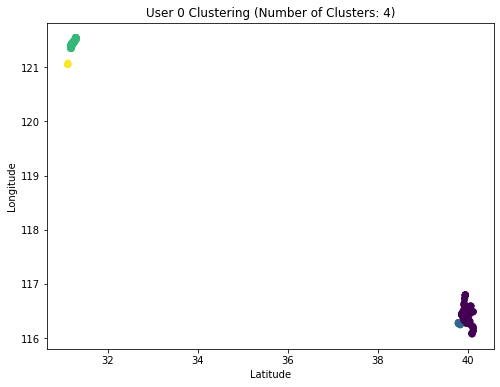

User 1 - No meaningful clustering found.


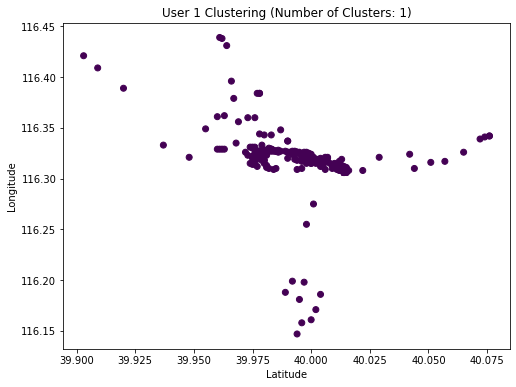

User 2 - Silhouette Score: 0.8247161898775894


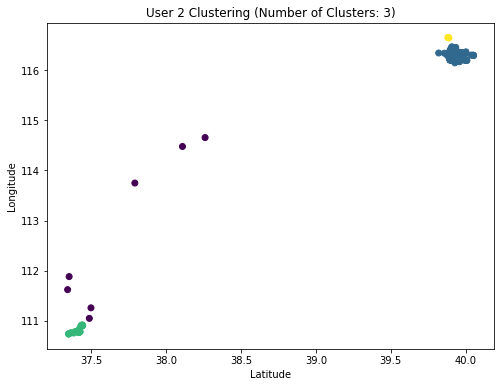

User 3 - Silhouette Score: 0.9387340207072642


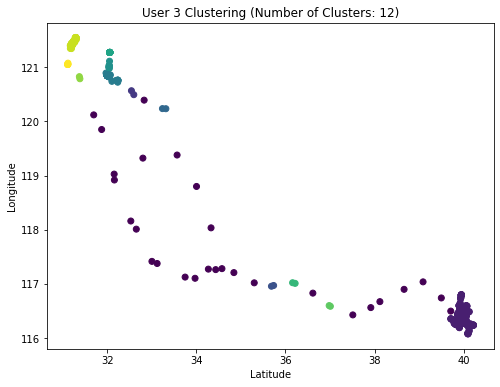

User 4 - Silhouette Score: 0.8274681591381919


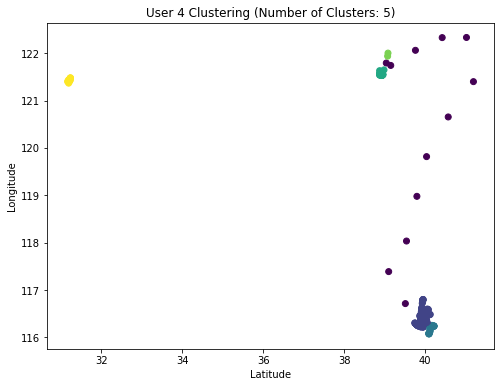

User 5 - Silhouette Score: 0.8848704540290642


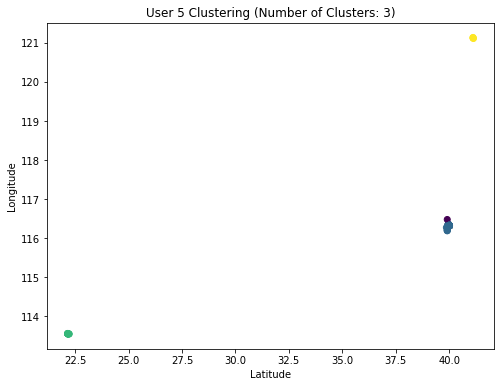

User 6 - Silhouette Score: 0.8228366625281726


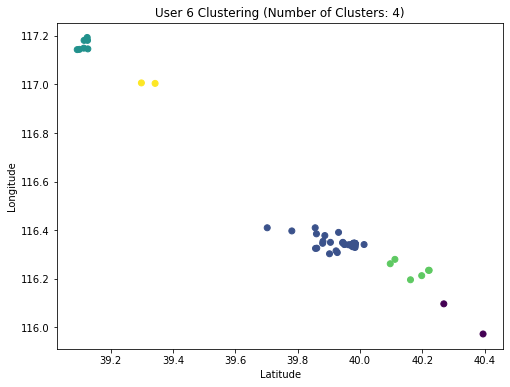

User 7 - Silhouette Score: 0.7793772907707928


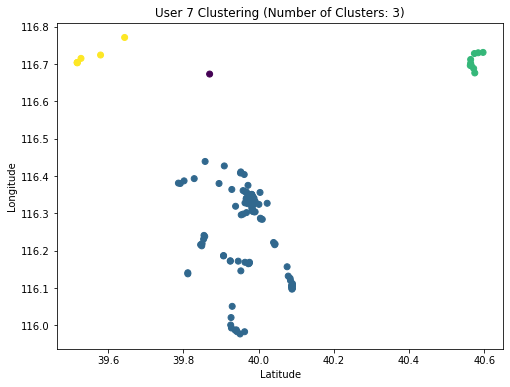

User 8 - No meaningful clustering found.


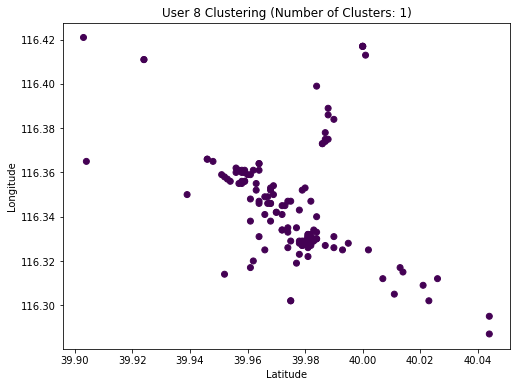

User 9 - No meaningful clustering found.


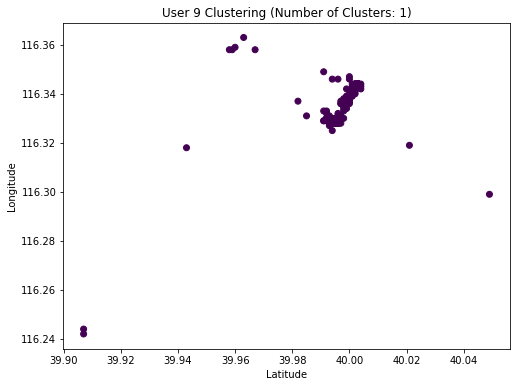

In [30]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define the maximum number of users to process (n)
max_users = 10
user_count = 0

for user_df in user_dataframes:
    user = user_df['User'].iloc[0]
    X = user_df[['Average Latitude', 'Average Longitude']]

    # Perform DBSCAN clustering without specifying the number of clusters
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(X)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # -1 represents noise points

    plt.figure(figsize=(8, 6))
    plt.scatter(X['Average Latitude'], X['Average Longitude'], c=labels, cmap='viridis')
    plt.title(f'User {user} Clustering (Number of Clusters: {num_clusters})', color='black')
    plt.xlabel('Latitude', color='black')
    plt.ylabel('Longitude', color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')

    # Calculate the goodness of clustering (silhouette score)
    if num_clusters > 1:
        silhouette_avg = silhouette_score(X, labels)
        print(f'User {user} - Silhouette Score: {silhouette_avg}')
    else:
        print(f'User {user} - No meaningful clustering found.')

    plt.show()

    user_count += 1
    if user_count >= max_users:
        break

**CLUSTERING ON THE PROCESSED DATA**

User 0 - Silhouette Score: 0.7668021578607366


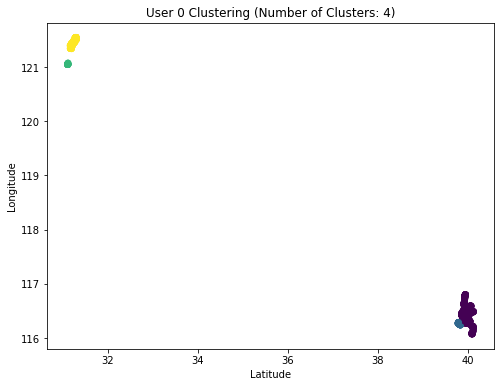

User 1 - No meaningful clustering found.


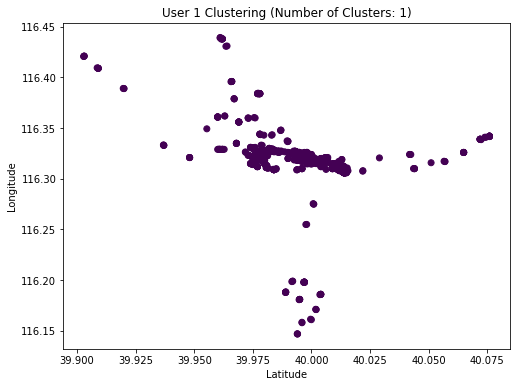

User 2 - Silhouette Score: 0.8470513471036494


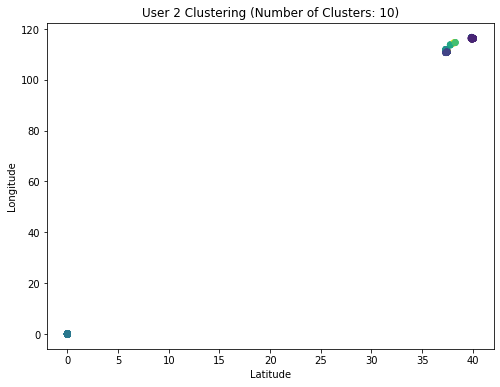

User 3 - Silhouette Score: 0.8347318907080538


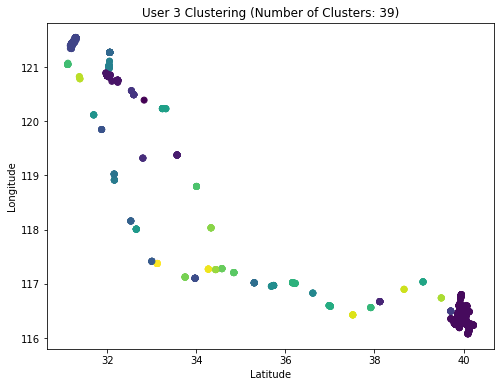

User 4 - Silhouette Score: 0.8446965546403395


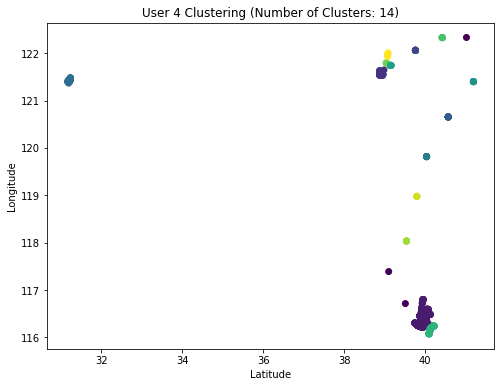

User 5 - Silhouette Score: 0.9022613944776743


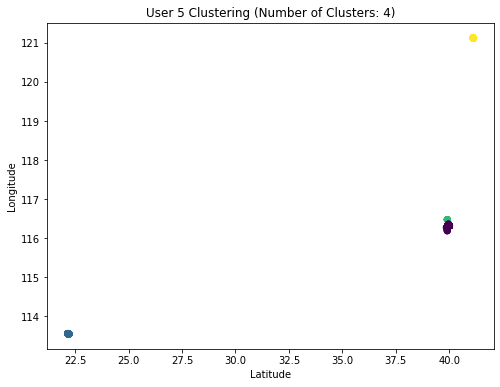

User 6 - Silhouette Score: 0.8728271128226047


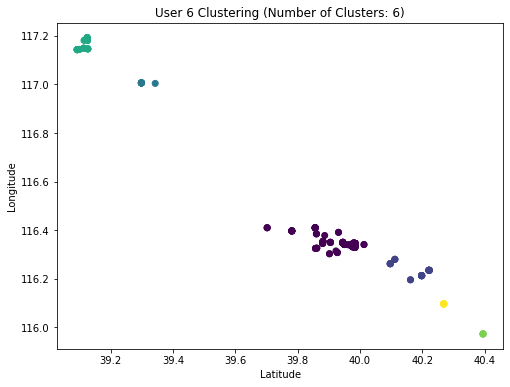

User 7 - Silhouette Score: 0.8431777823829427


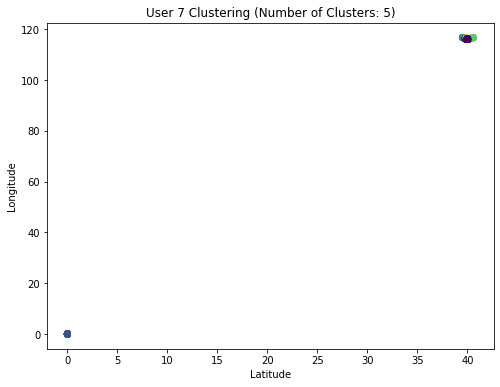

User 8 - Silhouette Score: 0.999787531855549


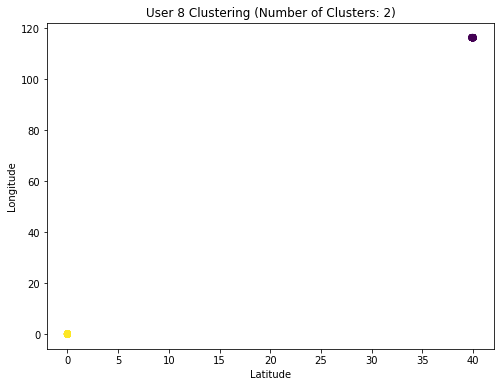

User 9 - No meaningful clustering found.


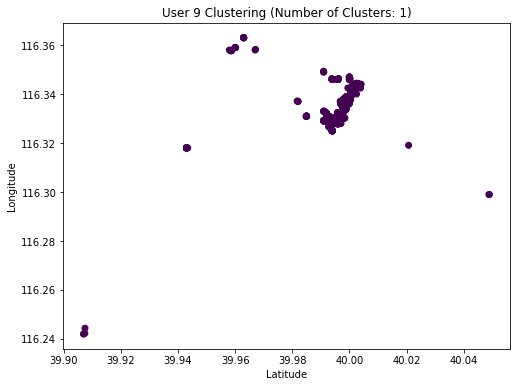

In [31]:
# Define the maximum number of users to process (n)
max_users = 10
user_count = 0

for user_df in final_user_dataframes:
    user = user_df['User'].iloc[0]
    X = user_df[['Average Latitude', 'Average Longitude']]

    # Perform DBSCAN clustering without specifying the number of clusters
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(X)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # -1 represents noise points

    plt.figure(figsize=(8, 6))
    plt.scatter(X['Average Latitude'], X['Average Longitude'], c=labels, cmap='viridis')
    plt.title(f'User {user} Clustering (Number of Clusters: {num_clusters})', color='black')
    plt.xlabel('Latitude', color='black')
    plt.ylabel('Longitude', color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')

    # Calculate the goodness of clustering (silhouette score)
    if num_clusters > 1:
        silhouette_avg = silhouette_score(X, labels)
        print(f'User {user} - Silhouette Score: {silhouette_avg}')
    else:
        print(f'User {user} - No meaningful clustering found.')

    plt.show()

    user_count += 1
    if user_count >= max_users:
        break

**TABLE OF CLUSTERING**

In [15]:
results = []

for user_df_original, user_df_processed in zip(user_dataframes, final_user_dataframes):
    user = user_df_original['User'].iloc[0]

    # Original Data
    X_original = user_df_original[['Average Latitude', 'Average Longitude']]
    dbscan_original = DBSCAN(eps=0.1, min_samples=2)
    labels_original = dbscan_original.fit_predict(X_original)
    num_clusters_original = len(set(labels_original)) - (1 if -1 in labels_original else 0)  # -1 represents noise points
    if num_clusters_original > 1:
        silhouette_avg_original = silhouette_score(X_original, labels_original)
    else:
        silhouette_avg_original = 0

    # Processed Data
    X_processed = user_df_processed[['Average Latitude', 'Average Longitude']]
    dbscan_processed = DBSCAN(eps=0.1, min_samples=2)
    labels_processed = dbscan_processed.fit_predict(X_processed)
    num_clusters_processed = len(set(labels_processed)) - (1 if -1 in labels_processed else 0)  # -1 represents noise points
    if num_clusters_processed > 1:
        silhouette_avg_processed = silhouette_score(X_processed, labels_processed)
    else:
        silhouette_avg_processed = 0

    results.append({
        'User': user,
        'NumClustersOriginal': num_clusters_original,
        'GoodnessOriginal': silhouette_avg_original,
        'NumClustersProcessed': num_clusters_processed,
        'GoodnessProcessed': silhouette_avg_processed
    })

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
results_df

,User,NumClustersOriginal,GoodnessOriginal,NumClustersProcessed,GoodnessProcessed
0,0,4,0.746127,4,0.766802
1,1,1,0.000000,1,0.000000
2,2,3,0.824716,10,0.847051
3,3,12,0.938734,39,0.834732
4,4,5,0.827468,14,0.844697
5,5,3,0.884870,4,0.902261
6,6,4,0.822837,6,0.872827
7,7,3,0.779377,5,0.843178
8,8,1,0.000000,2,0.999788
9,9,1,0.000000,1,0.000000


**CROSS USER CLUSTERING ON THE PROCESSED DATA**

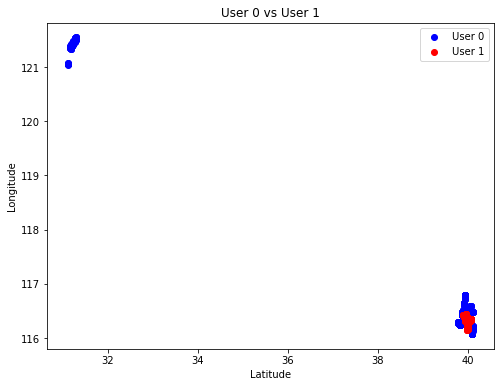

Number of Clusters: 4
Silhouette Score: 0.7665773405781933


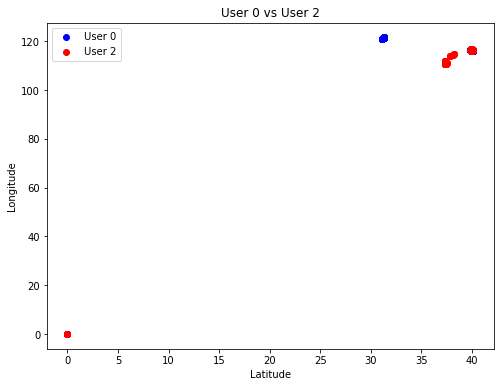

Number of Clusters: 11
Silhouette Score: 0.9516385516273882


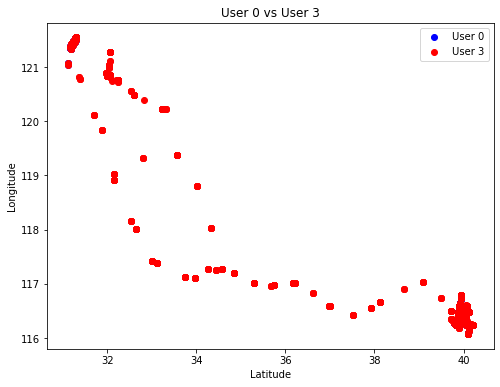

Number of Clusters: 39
Silhouette Score: 0.8276147307405035


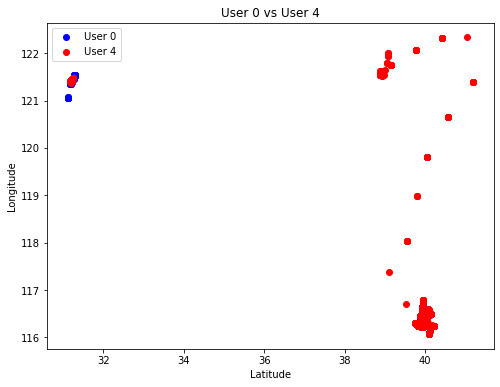

Number of Clusters: 14
Silhouette Score: 0.9640710813309469


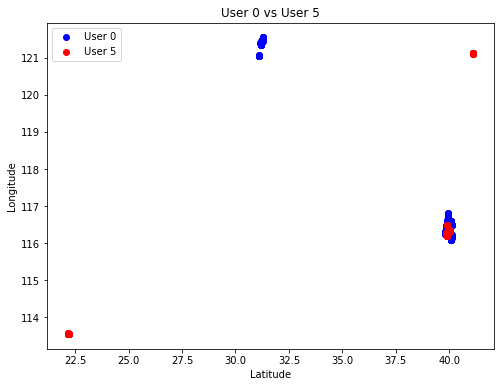

Number of Clusters: 5
Silhouette Score: 0.9850453420544591


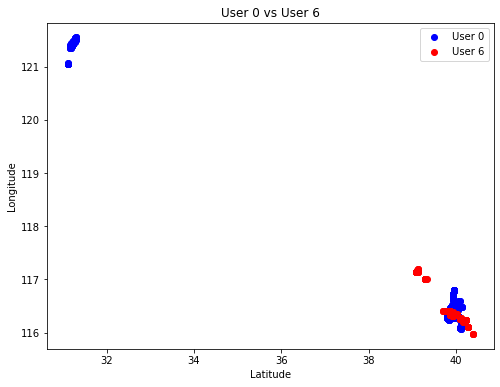

Number of Clusters: 7
Silhouette Score: 0.8363771929224532


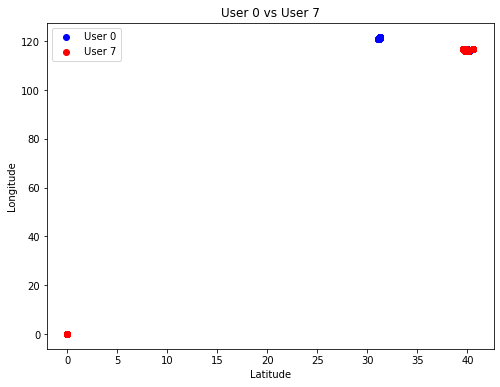

Number of Clusters: 6
Silhouette Score: 0.8792683512987082


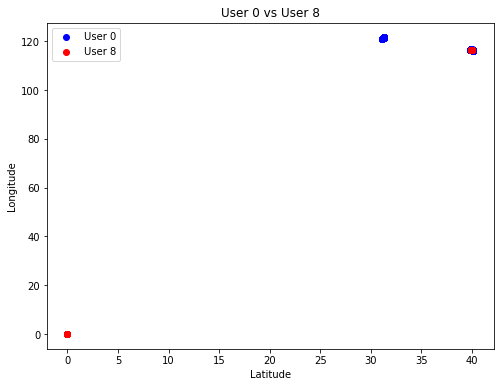

Number of Clusters: 5
Silhouette Score: 0.7631644336566529


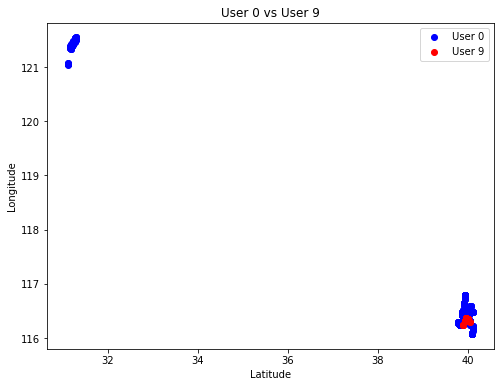

Number of Clusters: 3
Silhouette Score: 0.9878673828959736


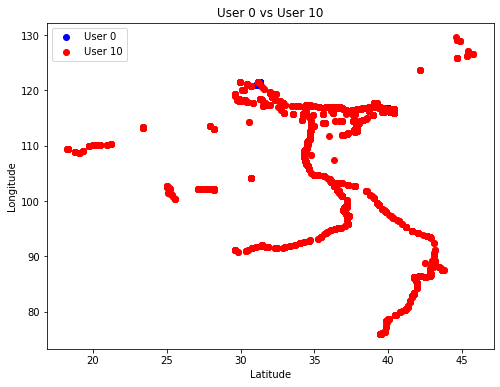

Number of Clusters: 312
Silhouette Score: 0.5610743984596368


In [29]:
# Generate all possible combinations of two users
user_combinations = []
for i in range(len(final_user_dataframes)):
    for j in range(i + 1, len(final_user_dataframes)):
        user_combinations.append((i, j))

# Define the maximum number of plots to generate (n)
max_plots = 10
plot_count = 0

# Create subplots for each user pair
for idx, (user1, user2) in enumerate(user_combinations):
    if plot_count >= max_plots:
        break 

    plt.figure(figsize=(8, 6))

    user1_data = final_user_dataframes[user1]
    user2_data = final_user_dataframes[user2]

    combined_data = pd.concat([user1_data, user2_data], ignore_index=True)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(combined_data[['Average Latitude', 'Average Longitude']])
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Calculate the goodness of clustering (silhouette score)
    if num_clusters > 1:
        silhouette_avg = silhouette_score(combined_data[['Average Latitude', 'Average Longitude']], labels)
    else:
        silhouette_avg = None

    plt.scatter(user1_data['Average Latitude'], user1_data['Average Longitude'], label=f'User {user1}', color='blue')
    plt.scatter(user2_data['Average Latitude'], user2_data['Average Longitude'], label=f'User {user2}', color='red')
    plt.xlabel('Latitude', color='black')
    plt.ylabel('Longitude', color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.title(f'User {user1} vs User {user2}', color='black')
    plt.legend()
    plt.show()

    print(f'Number of Clusters: {num_clusters}')
    print(f'Silhouette Score: {silhouette_avg}')
    
    plot_count += 1

**CROSS-USER SIMILARITY SCORE**

In [17]:
from sklearn.metrics import jaccard_score

# Generate all possible combinations of two users
user_combinations = []
for i in range(len(final_user_dataframes)):
    for j in range(i + 1, len(final_user_dataframes)):
        user_combinations.append((i, j))

results = []

# # Define the maximum number of rows (n)
# max_rows = 15

# Iterate through the pairs of users
for user1, user2 in user_combinations:
    # if len(results) >= max_rows:
    #     break  
    
    user1_data = final_user_dataframes[user1]
    user2_data = final_user_dataframes[user2]
    combined_data = pd.concat([user1_data, user2_data], ignore_index=True)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels_combined = dbscan.fit_predict(combined_data[['Average Latitude', 'Average Longitude']])
    num_clusters_combined = len(set(labels_combined)) - (1 if -1 in labels_combined else 0)

    # Calculate the goodness of clustering (silhouette score)
    if num_clusters_combined > 1:
        silhouette_avg_combined = silhouette_score(combined_data[['Average Latitude', 'Average Longitude']], labels_combined)
    else:
        silhouette_avg_combined = None

    num_clusters_1 = results_df.loc[user1, 'NumClustersProcessed']
    num_clusters_2 = results_df.loc[user2, 'NumClustersProcessed']
    goodness_1 = results_df.loc[user1, 'GoodnessProcessed']
    goodness_2 = results_df.loc[user2, 'GoodnessProcessed']

    # Extract cluster labels
    labels_user1 = labels_combined[:len(user1_data)]
    labels_user2 = labels_combined[len(user1_data):]
    max_length = max(len(labels_user1), len(labels_user2))
    labels_user1 = np.pad(labels_user1, (0, max_length - len(labels_user1)))
    labels_user2 = np.pad(labels_user2, (0, max_length - len(labels_user2)))
    
    # Calculate Similarity Score
    similarity_score = len(set(labels_user1).intersection(set(labels_user2))) / num_clusters_combined
    
    print(f'User1: {user1} User2: {user2} Similarity Score: {similarity_score}')
    results.append([user1, user2, num_clusters_1, goodness_1, num_clusters_2, goodness_2, num_clusters_combined, silhouette_avg_combined, similarity_score])

final_result_df = pd.DataFrame(results, columns=['User1', 'User2', 'NumClustersUser1', 'GoodnessOfClusteringUser1', 'NumClustersUser2', 'GoodnessOfClusteringUser2', 'NumClustersCombined', 'GoodnessOfClusteringCombined', 'SimilarityScore'])

User1: 0 User2: 1 Similarity Score: 0.25
User1: 0 User2: 2 Similarity Score: 0.09090909090909091
User1: 0 User2: 3 Similarity Score: 0.07692307692307693
User1: 0 User2: 4 Similarity Score: 0.14285714285714285
User1: 0 User2: 5 Similarity Score: 0.2
User1: 0 User2: 6 Similarity Score: 0.14285714285714285
User1: 0 User2: 7 Similarity Score: 0.16666666666666666
User1: 0 User2: 8 Similarity Score: 0.2
User1: 0 User2: 9 Similarity Score: 0.3333333333333333
User1: 0 User2: 10 Similarity Score: 0.00641025641025641
User1: 0 User2: 11 Similarity Score: 0.25
User1: 0 User2: 12 Similarity Score: 0.04
User1: 0 User2: 13 Similarity Score: 0.1111111111111111
User1: 0 User2: 14 Similarity Score: 0.2
User1: 0 User2: 15 Similarity Score: 0.25
User1: 0 User2: 16 Similarity Score: 0.25
User1: 0 User2: 17 Similarity Score: 0.09090909090909091
User1: 0 User2: 18 Similarity Score: 0.09090909090909091
User1: 0 User2: 19 Similarity Score: 0.16666666666666666
User1: 0 User2: 20 Similarity Score: 0.2
User1: 0 U

In [18]:
final_result_df.to_csv('SimilarityScores.csv', index=False)

**HEATMAP**

In [19]:
similarity_score_df = final_result_df[['User1', 'User2', 'SimilarityScore']]

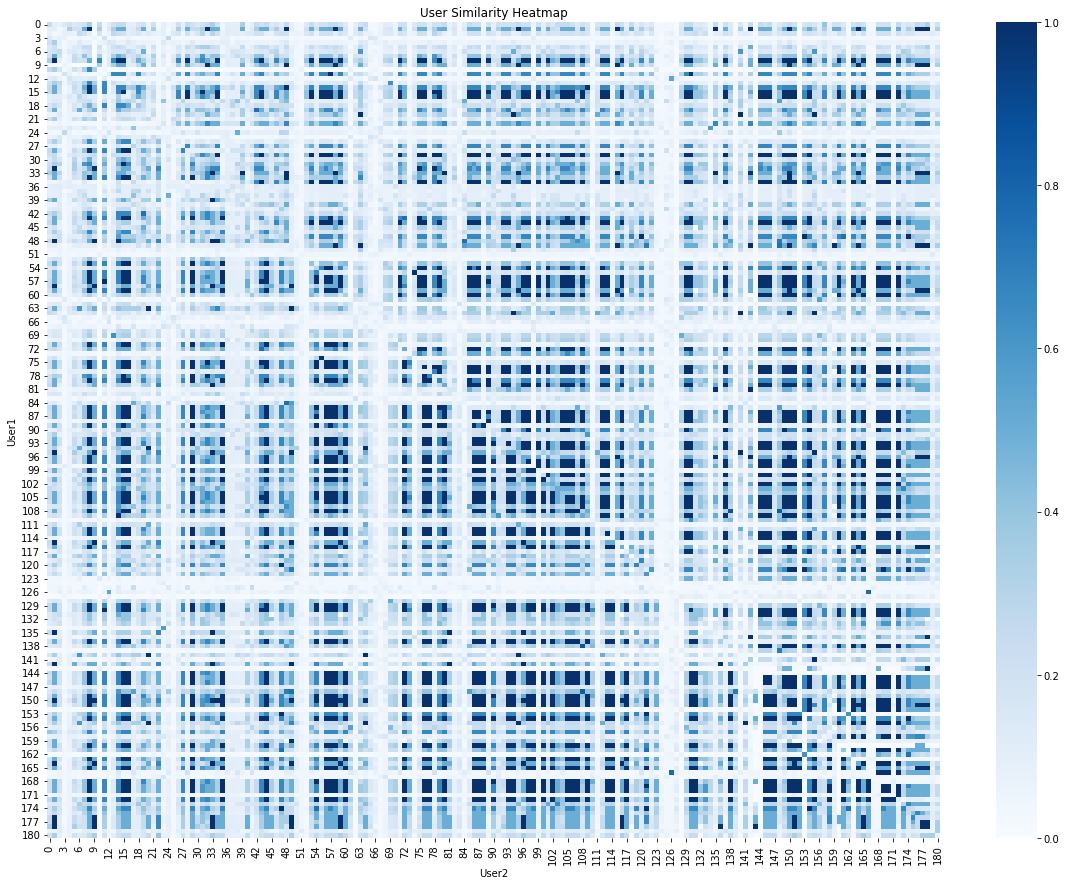

In [32]:
import seaborn as sns

# Create a pivot table for the heatmap
heatmap_data = similarity_score_df.pivot(index='User1', columns='User2', values='SimilarityScore')
heatmap_data = np.triu(heatmap_data) + np.tril(heatmap_data.T, -1)

plt.figure(figsize=(20, 15))
ax = sns.heatmap(heatmap_data, cmap='Blues', annot=False, cbar=True, vmin=0, vmax=1)
plt.xlabel('User2', color='black')
plt.ylabel('User1', color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('User Similarity Heatmap', color='black')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelcolor='black')

plt.show()

**CROSS-USER PLOTS**

In [33]:
def plot_user_clusters(user1, user2):

    plt.figure(figsize=(8, 6))

    user1_data = user_dataframes[user1]
    user2_data = user_dataframes[user2]
    combined_data = pd.concat([user1_data, user2_data], ignore_index=True)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(combined_data[['Average Latitude', 'Average Longitude']])
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Calculate the goodness of clustering (silhouette score)
    if num_clusters > 1:
        silhouette_avg = silhouette_score(combined_data[['Average Latitude', 'Average Longitude']], labels)
    else:
        silhouette_avg = None

    plt.scatter(user1_data['Average Latitude'], user1_data['Average Longitude'], label=f'User {user1}', color='blue')
    plt.scatter(user2_data['Average Latitude'], user2_data['Average Longitude'], label=f'User {user2}', color='red')
    plt.xlabel('Latitude', color='black')
    plt.ylabel('Longitude', color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.title(f'User {user1} vs User {user2}', color='black')
    plt.legend()
    plt.show()

    print(f'Number of Clusters: {num_clusters}')
    print(f'Silhouette Score: {silhouette_avg}')

**SIMILARITY SCORE = 1**

In [22]:
# Filter pairs with a similarity score of 1
similarity_1 = final_result_df[final_result_df['SimilarityScore'] == 1.0][['User1', 'User2', 'NumClustersUser1', 'GoodnessOfClusteringUser1', 'NumClustersUser2', 'GoodnessOfClusteringUser2', 'NumClustersCombined', 'GoodnessOfClusteringCombined']]

print("Pairs with Similarity Score of 1:")
similarity_1

Pairs with Similarity Score of 1:


,User1,User2,NumClustersUser1,GoodnessOfClusteringUser1,NumClustersUser2,GoodnessOfClusteringUser2,NumClustersCombined,GoodnessOfClusteringCombined
188,1,9,1,0.000000,1,0.000000,1,NaN
212,1,33,1,0.000000,1,0.000000,1,NaN
228,1,49,1,0.000000,0,0.000000,1,NaN
238,1,59,1,0.000000,1,0.000000,1,NaN
275,1,96,1,0.000000,1,0.000000,1,NaN
295,1,116,1,0.000000,1,0.000000,1,NaN
315,1,136,1,0.000000,2,0.830282,1,NaN
322,1,143,1,0.000000,1,0.000000,1,NaN
330,1,151,1,0.000000,1,0.000000,1,NaN
344,1,165,1,0.000000,1,0.000000,1,NaN


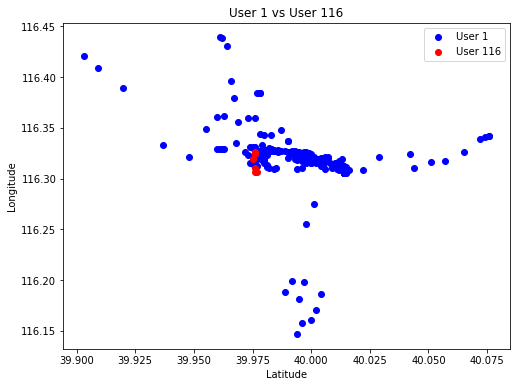

Number of Clusters: 1
Silhouette Score: None


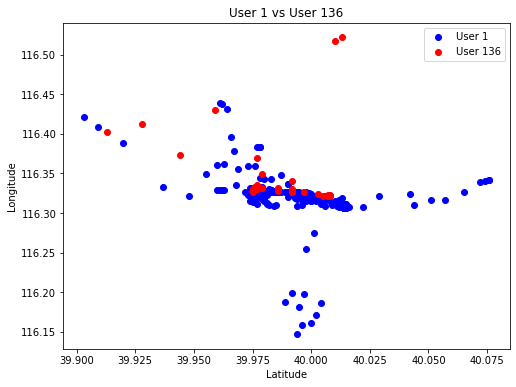

Number of Clusters: 1
Silhouette Score: None


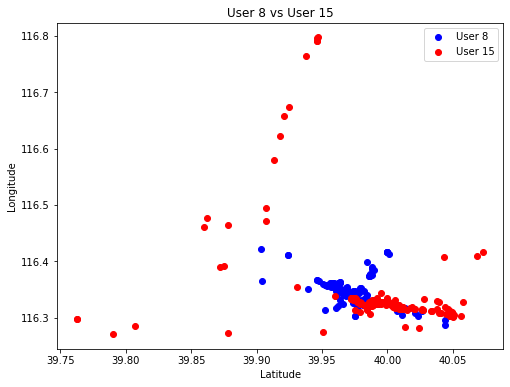

Number of Clusters: 1
Silhouette Score: None


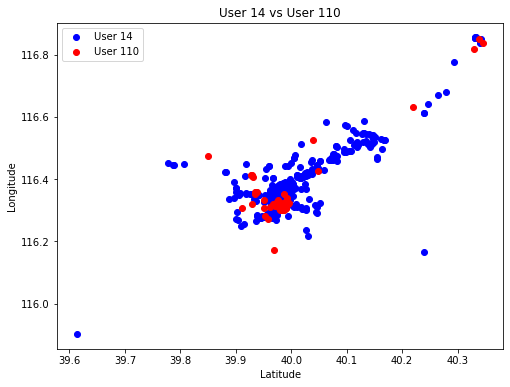

Number of Clusters: 1
Silhouette Score: None


In [34]:
user1_index = 1  
user2_index = 116 
plot_user_clusters(user1_index, user2_index)

user1_index = 1  
user2_index = 136 
plot_user_clusters(user1_index, user2_index)

user1_index = 8
user2_index = 15
plot_user_clusters(user1_index, user2_index)

user1_index = 14 
user2_index = 110 
plot_user_clusters(user1_index, user2_index)

In [35]:
def plot_user_clusters_processed(user1, user2):

    plt.figure(figsize=(8, 6))

    user1_data = final_user_dataframes[user1]
    user2_data = final_user_dataframes[user2]
    combined_data = pd.concat([user1_data, user2_data], ignore_index=True)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(combined_data[['Average Latitude', 'Average Longitude']])
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Calculate the goodness of clustering (silhouette score)
    if num_clusters > 1:
        silhouette_avg = silhouette_score(combined_data[['Average Latitude', 'Average Longitude']], labels)
    else:
        silhouette_avg = None

    plt.scatter(user1_data['Average Latitude'], user1_data['Average Longitude'], label=f'User {user1}', color='blue')
    plt.scatter(user2_data['Average Latitude'], user2_data['Average Longitude'], label=f'User {user2}', color='red')
    plt.xlabel('Latitude', color='black')
    plt.ylabel('Longitude', color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.title(f'User {user1} vs User {user2}', color='black')
    plt.legend()
    plt.show()

    print(f'Number of Clusters: {num_clusters}')
    print(f'Silhouette Score: {silhouette_avg}')

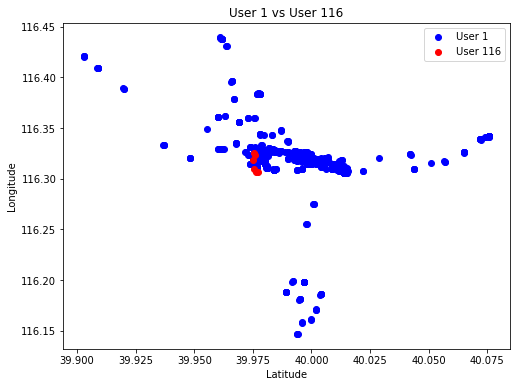

Number of Clusters: 1
Silhouette Score: None


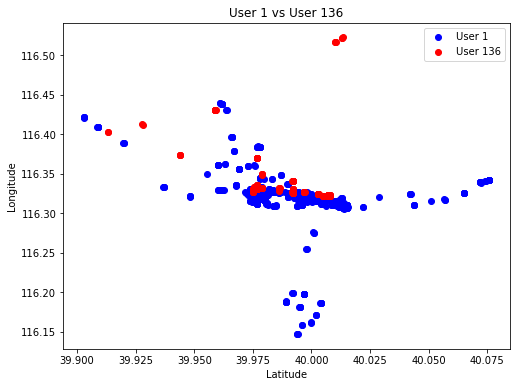

Number of Clusters: 1
Silhouette Score: None


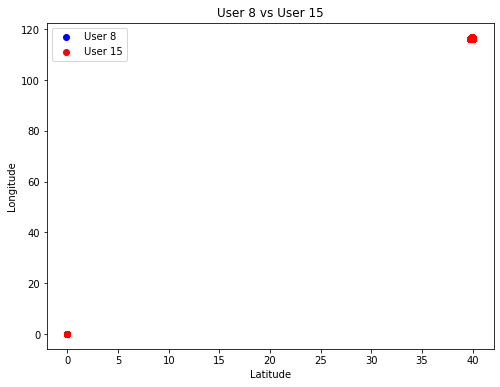

Number of Clusters: 2
Silhouette Score: 0.9995885767173203


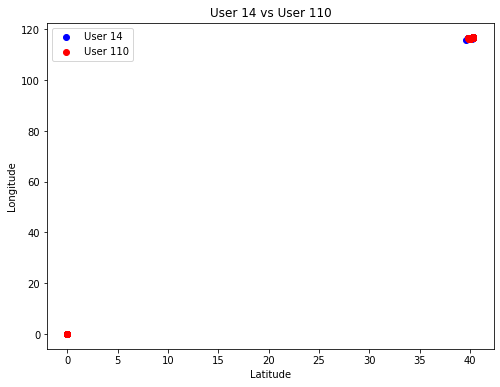

Number of Clusters: 2
Silhouette Score: 0.8053630673975751


In [36]:
user1_index = 1  
user2_index = 116 
plot_user_clusters_processed(user1_index, user2_index)

user1_index = 1  
user2_index = 136 
plot_user_clusters_processed(user1_index, user2_index)

user1_index = 8
user2_index = 15
plot_user_clusters_processed(user1_index, user2_index)

user1_index = 14 
user2_index = 110 
plot_user_clusters_processed(user1_index, user2_index)

**HIGH-SIMILARITY SCORE**

In [24]:
# Filter pairs with a similarity score in (0.75, 1)
similarity_high = final_result_df[(final_result_df['SimilarityScore'] > 0.75) & (final_result_df['SimilarityScore'] < 1.0)][['User1', 'User2', 'NumClustersUser1', 'GoodnessOfClusteringUser1', 'NumClustersUser2', 'GoodnessOfClusteringUser2', 'NumClustersCombined', 'GoodnessOfClusteringCombined', 'SimilarityScore']]

print("Pairs with Similarity Score in (0.75, 1):")
similarity_high

Pairs with Similarity Score in (0.75, 1):


,User1,User2,NumClustersUser1,GoodnessOfClusteringUser1,NumClustersUser2,GoodnessOfClusteringUser2,NumClustersCombined,GoodnessOfClusteringCombined,SimilarityScore
13800,108,139,6,0.950087,7,0.948589,7,0.949022,0.857143
13810,108,149,6,0.950087,5,0.788499,6,0.925508,0.833333
14971,126,167,27,0.775178,29,0.787668,32,0.788946,0.781250


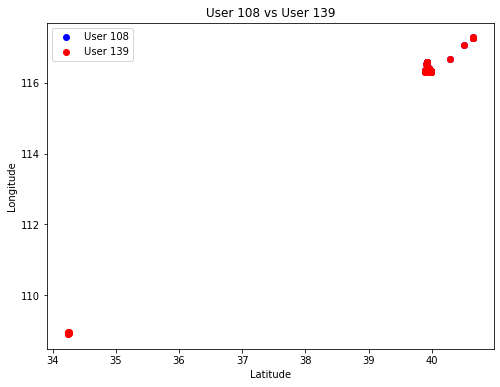

Number of Clusters: 6
Silhouette Score: 0.8997686433150279


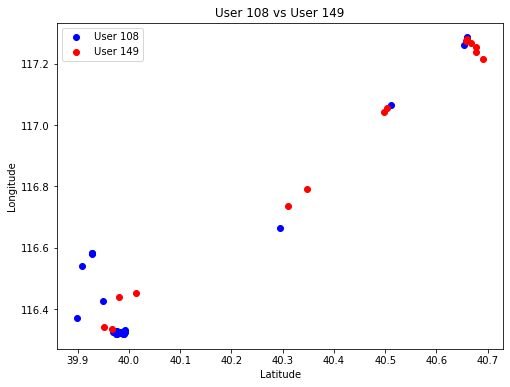

Number of Clusters: 5
Silhouette Score: 0.8227063359201182


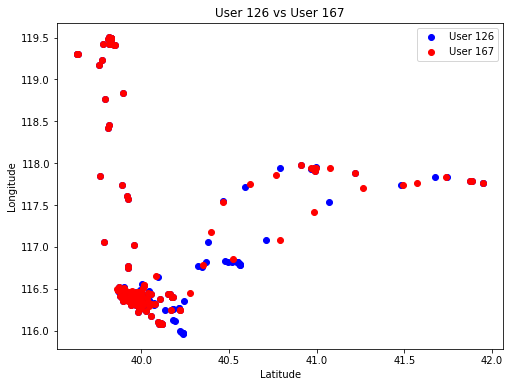

Number of Clusters: 26
Silhouette Score: 0.7815350570061455


In [37]:
user1_index = 108
user2_index = 139
plot_user_clusters(user1_index, user2_index)

user1_index = 108
user2_index = 149
plot_user_clusters(user1_index, user2_index)

user1_index = 126
user2_index = 167
plot_user_clusters(user1_index, user2_index)

**SIMILARITY SCORE = 0**

In [26]:
# Filter pairs with a similarity score of 0
similarity_0 = final_result_df[final_result_df['SimilarityScore'] == 0.0][['User1', 'User2', 'NumClustersUser1', 'GoodnessOfClusteringUser1', 'NumClustersUser2', 'GoodnessOfClusteringUser2', 'NumClustersCombined', 'GoodnessOfClusteringCombined']]

print("Pairs with Similarity Score of 0:")
similarity_0

Pairs with Similarity Score of 0:


,User1,User2,NumClustersUser1,GoodnessOfClusteringUser1,NumClustersUser2,GoodnessOfClusteringUser2,NumClustersCombined,GoodnessOfClusteringCombined
7241,45,132,2,0.993704,4,0.936390,6,0.963302
7671,48,160,6,0.809010,1,0.000000,7,0.906494
9026,59,118,1,0.000000,9,0.859700,10,0.925172
9040,59,132,1,0.000000,4,0.936390,5,0.959292
9172,60,143,2,0.999985,1,0.000000,3,0.976413
9189,60,160,2,0.999985,1,0.000000,3,0.998179
10563,72,160,2,0.999902,1,0.000000,3,0.998485
11093,77,160,2,0.999757,1,0.000000,3,0.998432
13748,107,160,2,0.999983,1,0.000000,3,0.998839
13893,109,160,2,0.999666,1,0.000000,3,0.998221


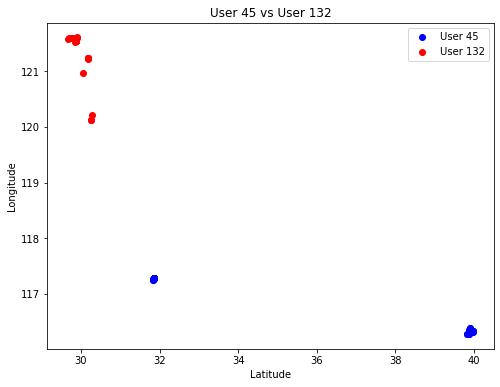

Number of Clusters: 5
Silhouette Score: 0.9205268942052811


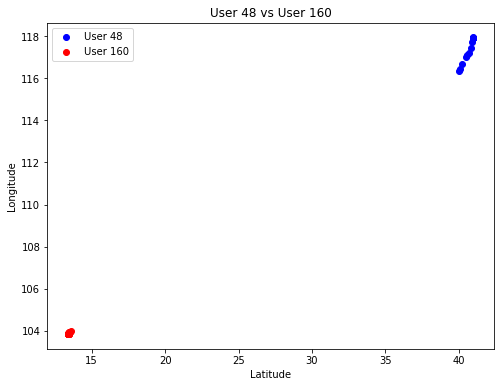

Number of Clusters: 2
Silhouette Score: 0.8733012987224681


In [38]:
user1_index = 45
user2_index = 132
plot_user_clusters(user1_index, user2_index)

user1_index = 48
user2_index = 160
plot_user_clusters(user1_index, user2_index)

**HISTOGRAM**

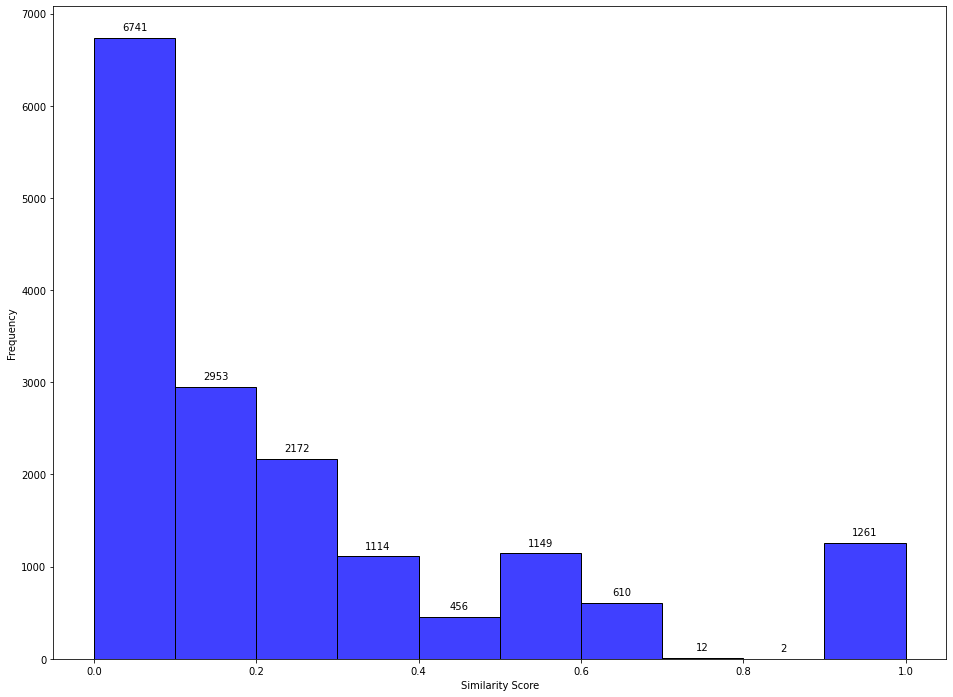

In [40]:
plt.figure(figsize=(16, 12))

# Create a histogram using Seaborn
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sns.histplot(final_result_df['SimilarityScore'], bins=bins, color='blue', edgecolor='black')

ax = plt.gca()
ax.tick_params(axis='both', colors='black')
ax.set_xlabel('Similarity Score', color='black')
ax.set_ylabel('Frequency', color='black')

# Show the frequency on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')

plt.show()